## Device Stuff

In [100]:
import torch

#Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Dataset

In [101]:
import os
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [102]:
from utils import get_classes_indexes

In [103]:
source_folder = os.path.join('data', 'internal', 'preprocessed_videos')

def create_dataframe(videos_root):
    data = []
    
    classes_to_extract = os.listdir(videos_root)
    
    classes_data = get_classes_indexes(class_file_name="data/raw/dataset/wlasl_class_list.txt", classes_to_extract=classes_to_extract)

    CLASS_TO_IDX = {class_name : idx for (idx, class_name) in  classes_data}
    IDX_TO_CLASS = {idx : class_name for (idx, class_name) in  classes_data}
    
    for class_name in os.listdir(videos_root):
        class_path = os.path.join(videos_root, class_name)
        for name in os.listdir(class_path):
            name = Path(name).stem
            data.append([name, CLASS_TO_IDX[class_name], class_name])
    return pd.DataFrame(data, columns=['video_name', 'class_id', 'class_name'])

dataset = create_dataframe(source_folder)

dataset.sample(20)

,video_name,class_id,class_name
43,06787,1636,blow
16,WIN_20231127_00_27_20_Pro,632,airplane
300,WIN_20231127_20_21_15_Pro,1999,whistle
13,WIN_20231127_00_27_05_Pro,632,airplane
131,WIN_20231127_19_39_47_Pro,159,know
201,WIN_20231127_20_10_29_Pro,1164,me
321,WIN_20231127_20_24_47_Pro,179,you
40,WIN_20231127_19_29_18_Pro,259,baby
231,69404,566,my
61,WIN_20231127_19_33_47_Pro,1636,blow


In [104]:
import cv2

max_frame_count = 0

for key, row in dataset.iterrows():
    class_name = row['class_name']
    file_name = row['video_name']
    file_path = os.path.join(source_folder, class_name, file_name+'.mp4')
    cap = cv2.VideoCapture(file_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    max_frame_count = max(max_frame_count, length)
    
print('Maximum frame count:',max_frame_count)

Maximum frame count: 168


In [105]:
IDX_TO_CLASS = [ c_id for i, c_id in enumerate(set(dataset.class_id))]
CLASS_TO_IDX = { c_id: i for i, c_id in enumerate(IDX_TO_CLASS)}

In [106]:
from os.path import exists
import torch.nn.functional as F

class ASLDataset(Dataset):
    """
    A custom dataset class for loading American Sign Language (ASL) videos and their corresponding labels.

    Args:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        dataset_df (DataFrame): Pandas dataframe with information about videos
        max_frame_count (int): Maximum length of video in frames.
        ohe (OneHotEncoder): Required to encode class id to one hot numeric array.

    Attributes:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        name_with_label (dict): A dictionary mapping video names to their labels.
        classes (list): A list of class names.
    """

    def __init__(self, tensors_folder: str, dataset_df: pd.DataFrame, max_frame_count: int) -> None:
        # Default frame (set of points) to insert in short videos to make all videos equal in length
        default_frame = [0] * (21 * 3 * 2 + 33 * 3)
        
        self.tensor_sequences = []
        self.targets = []
        for i, row in dataset_df.iterrows():
            path_to_tensor = tensors_folder + '/' + row["video_name"] + '.pt'
            
            if not exists(path_to_tensor):
                continue
            
            # Open the video file using OpenCV
            tensor = torch.load(path_to_tensor)

            # Change length of video (not a video but sequence of frames with points coordinates in each frame)
            # pad_right = [default_frame for _ in range(0, max_frame_count - tensor.shape[0])]
            # pad_right = torch.tensor(pad_right)
            # self.tensor_sequences.append(torch.cat((pad_right, F.normalize(tensor.float(), dim=1))))
            self.tensor_sequences.append(F.normalize(tensor.float(), dim=1))
            self.targets.append(CLASS_TO_IDX[dataset_df["class_id"][i]])
        self.targets = torch.tensor(self.targets)
            
            
    def __len__(self):
        """
        Returns the number of videos in the dataset.

        Returns:
            int: The number of videos in the dataset.
        """
        return len(self.targets)

    def __getitem__(self, index):
        """
        Retrieves a video and its corresponding label from the dataset.

        Args:
            index (int): The index of the video to retrieve.

        Returns:
            tuple: A tuple containing the video frames as a PyTorch tensor and the label.
        """

        return self.tensor_sequences[index].float(), self.targets[index].long()


In [107]:
def read_classes(path):
    classes = dict()
    with open(path, 'r') as file:
        for line in file:
            line = line.strip().split('\t')
            key = int(line[0])
            value = line[1]
            classes[key] = value
    return classes

In [108]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [109]:
classes = read_classes('data/raw/dataset/wlasl_class_list.txt')

train_dataset = ASLDataset('data/internal/features', train, max_frame_count)
#val_dataset = ASLDataset('data/internal/features', val, max_frame_count)
test_dataset = ASLDataset('data/internal/features', test, max_frame_count)

In [110]:
# Create dataloaders
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
#print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 284
Test size: 71


## Model

In [111]:
import torch.nn as nn

class SequenceModel(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.lstm = nn.Sequential(
            nn.LSTM(input_size, 64, 1, batch_first=True, bidirectional=True),
        )
        self.linear = nn.Sequential(
            nn.Linear(64 * 2, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])

        return x

## Training

In [112]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm


def train_model(model: nn.Module, epochs: int, criterion, optimizer, ckpt_path='models/best.pt'):
    """
    Function that trains model using number of epochs, loss function, optimizer.
    Can use validation or test data set for evaluation.
    Calculates f1 score.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    epochs: int
      Number of train epochs
    criterion
      The loss function from pytorch
    optimizer
      The optimizer from pytorch
    """

    model.train()
    model.to(device)

    history = {'train_losses': [], 'test_losses': [],
               'train_scores': [], 'test_scores': []}

    # Train the model
    for epoch in range(epochs):
        model.train()

        predicted_train = []
        true_train = []

        train_loss = 0.0

        bar = tqdm(train_dataloader)
        iterations = 0

        for inputs, targets in bar:
          
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_train.append(item.cpu().numpy())
            for item in targets:
                true_train.append(item.cpu().numpy())
            iterations += 1
            bar.set_postfix(
                ({"loss": f"{train_loss/(iterations*train_dataloader.batch_size)}"}))

        # Computing loss
        train_loss /= len(train_dataset)
        # Computing f1 score
        train_f1 = f1_score(true_train, predicted_train, average="macro")

        # Printing information in the end of train loop
        test_loss, test_f1 = test_model(model, criterion, test_dataloader)

        history['train_losses'].append(train_loss)
        history['test_losses'].append(test_loss)
        history['train_scores'].append(train_f1)
        history['test_scores'].append(test_f1)

        if test_f1 > max(history['test_scores']):
            torch.save(model.state_dict(), ckpt_path)

        print(f"Epoch {epoch+1} train (loss: {train_loss:.4f}, f1 score: {train_f1:.4f}) test (loss: {test_loss:.4f}, f1 score: {test_f1:.4f})")

    return history


def test_model(model: nn.Module, criterion, test_dataloader: DataLoader):
    """
    Function that evaluates model on specified dataloader
    by specified loss function.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    criterion
      The loss function from pytorch
    test_dataloader: DataLoader
      The dataset for testing model

    Returns
    -------
    float: loss of model on given dataset
    float: f1 score of model on given dataset
    """

    model.eval()
    model.to(device)

    # Test loss value
    test_loss = 0.0

    # Lists for calculation f1 score
    predicted_test = []
    true_test = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_test.append(item.cpu().numpy())
            for item in targets:
                true_test.append(item.cpu().numpy())

    # Computation of test loss
    test_loss /= len(test_dataloader)

    # Computation of f1 score
    test_f1 = f1_score(true_test, predicted_test, average="macro")
    return test_loss.item(), test_f1

In [120]:
model = SequenceModel(input_size=225, output_size=len(IDX_TO_CLASS))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [121]:
history = train_model(model, 200, criterion, optimizer, ckpt_path='models/simple_lstm/best.pt')

100%|██████████| 284/284 [00:01<00:00, 174.14it/s, loss=2.459211399857427] 


Epoch 1 train (loss: 2.4592, f1 score: 0.0350) test (loss: 2.4646, f1 score: 0.0110)


100%|██████████| 284/284 [00:01<00:00, 203.86it/s, loss=2.4250944298757635]


Epoch 2 train (loss: 2.4251, f1 score: 0.0271) test (loss: 2.4374, f1 score: 0.0285)


100%|██████████| 284/284 [00:01<00:00, 205.16it/s, loss=2.412460806504102] 


Epoch 3 train (loss: 2.4125, f1 score: 0.0320) test (loss: 2.4244, f1 score: 0.0274)


100%|██████████| 284/284 [00:01<00:00, 200.38it/s, loss=2.405267320888143] 


Epoch 4 train (loss: 2.4053, f1 score: 0.0371) test (loss: 2.4256, f1 score: 0.0278)


100%|██████████| 284/284 [00:01<00:00, 188.53it/s, loss=2.3913853684781303]


Epoch 5 train (loss: 2.3914, f1 score: 0.0495) test (loss: 2.4375, f1 score: 0.0094)


100%|██████████| 284/284 [00:01<00:00, 204.49it/s, loss=2.4019270820516936]


Epoch 6 train (loss: 2.4019, f1 score: 0.0517) test (loss: 2.4255, f1 score: 0.0256)


100%|██████████| 284/284 [00:01<00:00, 207.10it/s, loss=2.389644258039098] 


Epoch 7 train (loss: 2.3896, f1 score: 0.0407) test (loss: 2.4424, f1 score: 0.0256)


100%|██████████| 284/284 [00:01<00:00, 212.39it/s, loss=2.366644461389998] 


Epoch 8 train (loss: 2.3666, f1 score: 0.0592) test (loss: 2.4323, f1 score: 0.0248)


100%|██████████| 284/284 [00:01<00:00, 209.11it/s, loss=2.3492089417618764]


Epoch 9 train (loss: 2.3492, f1 score: 0.0711) test (loss: 2.4226, f1 score: 0.0445)


100%|██████████| 284/284 [00:01<00:00, 215.65it/s, loss=2.3367444083724225]


Epoch 10 train (loss: 2.3367, f1 score: 0.0596) test (loss: 2.4323, f1 score: 0.0278)


100%|██████████| 284/284 [00:01<00:00, 208.96it/s, loss=2.319374925443824] 


Epoch 11 train (loss: 2.3194, f1 score: 0.0622) test (loss: 2.4228, f1 score: 0.0676)


100%|██████████| 284/284 [00:01<00:00, 204.22it/s, loss=2.295916542620726] 


Epoch 12 train (loss: 2.2959, f1 score: 0.0646) test (loss: 2.4356, f1 score: 0.0244)


100%|██████████| 284/284 [00:01<00:00, 204.66it/s, loss=2.2811811364872354]


Epoch 13 train (loss: 2.2812, f1 score: 0.0604) test (loss: 2.4330, f1 score: 0.0418)


100%|██████████| 284/284 [00:01<00:00, 207.15it/s, loss=2.280980788276229] 


Epoch 14 train (loss: 2.2810, f1 score: 0.0628) test (loss: 2.4240, f1 score: 0.0696)


100%|██████████| 284/284 [00:01<00:00, 207.58it/s, loss=2.2555616217809664]


Epoch 15 train (loss: 2.2556, f1 score: 0.0665) test (loss: 2.3801, f1 score: 0.0651)


100%|██████████| 284/284 [00:01<00:00, 214.47it/s, loss=2.2460830717439384]


Epoch 16 train (loss: 2.2461, f1 score: 0.0671) test (loss: 2.3770, f1 score: 0.0503)


100%|██████████| 284/284 [00:01<00:00, 209.48it/s, loss=2.221852083231362] 


Epoch 17 train (loss: 2.2219, f1 score: 0.0712) test (loss: 2.4005, f1 score: 0.0872)


100%|██████████| 284/284 [00:01<00:00, 215.53it/s, loss=2.2057922009221267]


Epoch 18 train (loss: 2.2058, f1 score: 0.1034) test (loss: 2.3452, f1 score: 0.0905)


100%|██████████| 284/284 [00:01<00:00, 204.51it/s, loss=2.1719773460809195]


Epoch 19 train (loss: 2.1720, f1 score: 0.0871) test (loss: 2.2854, f1 score: 0.0730)


100%|██████████| 284/284 [00:01<00:00, 205.15it/s, loss=2.1760703894558926]


Epoch 20 train (loss: 2.1761, f1 score: 0.1176) test (loss: 2.3308, f1 score: 0.0925)


100%|██████████| 284/284 [00:01<00:00, 200.65it/s, loss=2.1707310412131564]


Epoch 21 train (loss: 2.1707, f1 score: 0.0981) test (loss: 2.3269, f1 score: 0.0777)


100%|██████████| 284/284 [00:01<00:00, 207.41it/s, loss=2.146795194333708] 


Epoch 22 train (loss: 2.1468, f1 score: 0.0996) test (loss: 2.2891, f1 score: 0.0807)


100%|██████████| 284/284 [00:01<00:00, 202.17it/s, loss=2.1351586737683124]


Epoch 23 train (loss: 2.1352, f1 score: 0.1075) test (loss: 2.2938, f1 score: 0.0768)


100%|██████████| 284/284 [00:01<00:00, 202.63it/s, loss=2.109844913260198] 


Epoch 24 train (loss: 2.1098, f1 score: 0.0995) test (loss: 2.3008, f1 score: 0.0748)


100%|██████████| 284/284 [00:01<00:00, 192.68it/s, loss=2.110920976480128] 


Epoch 25 train (loss: 2.1109, f1 score: 0.1083) test (loss: 2.2864, f1 score: 0.0822)


100%|██████████| 284/284 [00:01<00:00, 192.66it/s, loss=2.0787668241791324]


Epoch 26 train (loss: 2.0788, f1 score: 0.1119) test (loss: 2.2766, f1 score: 0.0806)


100%|██████████| 284/284 [00:01<00:00, 191.25it/s, loss=2.0814926538249137]


Epoch 27 train (loss: 2.0815, f1 score: 0.1304) test (loss: 2.2398, f1 score: 0.0768)


100%|██████████| 284/284 [00:01<00:00, 193.91it/s, loss=2.06107257390526]  


Epoch 28 train (loss: 2.0611, f1 score: 0.1320) test (loss: 2.2558, f1 score: 0.1205)


100%|██████████| 284/284 [00:01<00:00, 192.83it/s, loss=2.0481288350174123]


Epoch 29 train (loss: 2.0481, f1 score: 0.1309) test (loss: 2.2489, f1 score: 0.1126)


100%|██████████| 284/284 [00:01<00:00, 191.10it/s, loss=2.0327505383797932]


Epoch 30 train (loss: 2.0328, f1 score: 0.1505) test (loss: 2.2491, f1 score: 0.0731)


100%|██████████| 284/284 [00:01<00:00, 196.97it/s, loss=2.0213215695300573]


Epoch 31 train (loss: 2.0213, f1 score: 0.1515) test (loss: 2.2309, f1 score: 0.1169)


100%|██████████| 284/284 [00:01<00:00, 197.76it/s, loss=2.011160586239167] 


Epoch 32 train (loss: 2.0112, f1 score: 0.2011) test (loss: 2.2175, f1 score: 0.1164)


100%|██████████| 284/284 [00:01<00:00, 203.03it/s, loss=1.9894229906125807]


Epoch 33 train (loss: 1.9894, f1 score: 0.2118) test (loss: 2.2137, f1 score: 0.1393)


100%|██████████| 284/284 [00:01<00:00, 199.71it/s, loss=1.9300403860463222]


Epoch 34 train (loss: 1.9300, f1 score: 0.2255) test (loss: 1.9810, f1 score: 0.1158)


100%|██████████| 284/284 [00:01<00:00, 197.32it/s, loss=1.8071822529317627]


Epoch 35 train (loss: 1.8072, f1 score: 0.2266) test (loss: 1.8222, f1 score: 0.2009)


100%|██████████| 284/284 [00:01<00:00, 206.57it/s, loss=1.6566334600284907]


Epoch 36 train (loss: 1.6566, f1 score: 0.3123) test (loss: 1.9100, f1 score: 0.2408)


100%|██████████| 284/284 [00:01<00:00, 197.44it/s, loss=1.6461046779082276]


Epoch 37 train (loss: 1.6461, f1 score: 0.3211) test (loss: 1.6914, f1 score: 0.2289)


100%|██████████| 284/284 [00:01<00:00, 197.15it/s, loss=1.5303372100100552]


Epoch 38 train (loss: 1.5303, f1 score: 0.3312) test (loss: 1.6680, f1 score: 0.2661)


100%|██████████| 284/284 [00:01<00:00, 206.87it/s, loss=1.4976786850676151]


Epoch 39 train (loss: 1.4977, f1 score: 0.3314) test (loss: 1.6279, f1 score: 0.2518)


100%|██████████| 284/284 [00:01<00:00, 200.56it/s, loss=1.474516288219938] 


Epoch 40 train (loss: 1.4745, f1 score: 0.3625) test (loss: 1.5957, f1 score: 0.3209)


100%|██████████| 284/284 [00:01<00:00, 197.58it/s, loss=1.492086546744784] 


Epoch 41 train (loss: 1.4921, f1 score: 0.3920) test (loss: 1.6672, f1 score: 0.2716)


100%|██████████| 284/284 [00:01<00:00, 194.77it/s, loss=1.434811560660076] 


Epoch 42 train (loss: 1.4348, f1 score: 0.3572) test (loss: 1.5509, f1 score: 0.3470)


100%|██████████| 284/284 [00:01<00:00, 190.85it/s, loss=1.4140876084238185]


Epoch 43 train (loss: 1.4141, f1 score: 0.3817) test (loss: 1.5911, f1 score: 0.3298)


100%|██████████| 284/284 [00:01<00:00, 194.99it/s, loss=1.3867722227251236]


Epoch 44 train (loss: 1.3868, f1 score: 0.3824) test (loss: 1.5794, f1 score: 0.3108)


100%|██████████| 284/284 [00:01<00:00, 195.33it/s, loss=1.3699643661425462]


Epoch 45 train (loss: 1.3700, f1 score: 0.3933) test (loss: 1.5707, f1 score: 0.2927)


100%|██████████| 284/284 [00:01<00:00, 196.74it/s, loss=1.3830275357058142]


Epoch 46 train (loss: 1.3830, f1 score: 0.4247) test (loss: 1.5631, f1 score: 0.3475)


100%|██████████| 284/284 [00:01<00:00, 199.51it/s, loss=1.308234304963598] 


Epoch 47 train (loss: 1.3082, f1 score: 0.4358) test (loss: 1.4223, f1 score: 0.4093)


100%|██████████| 284/284 [00:01<00:00, 195.03it/s, loss=1.3034666188513782]


Epoch 48 train (loss: 1.3035, f1 score: 0.4531) test (loss: 1.4477, f1 score: 0.4352)


100%|██████████| 284/284 [00:01<00:00, 202.14it/s, loss=1.233900783360529] 


Epoch 49 train (loss: 1.2339, f1 score: 0.4626) test (loss: 1.4485, f1 score: 0.3994)


100%|██████████| 284/284 [00:01<00:00, 202.24it/s, loss=1.2092465148946847]


Epoch 50 train (loss: 1.2092, f1 score: 0.5071) test (loss: 1.4941, f1 score: 0.2633)


100%|██████████| 284/284 [00:01<00:00, 193.00it/s, loss=1.212946499697864] 


Epoch 51 train (loss: 1.2129, f1 score: 0.5078) test (loss: 1.3099, f1 score: 0.5124)


100%|██████████| 284/284 [00:01<00:00, 204.87it/s, loss=1.1758180789806894]


Epoch 52 train (loss: 1.1758, f1 score: 0.5194) test (loss: 1.3145, f1 score: 0.4637)


100%|██████████| 284/284 [00:01<00:00, 197.42it/s, loss=1.1436499707338492]


Epoch 53 train (loss: 1.1436, f1 score: 0.5040) test (loss: 1.3847, f1 score: 0.4594)


100%|██████████| 284/284 [00:01<00:00, 198.76it/s, loss=1.153611200691109] 


Epoch 54 train (loss: 1.1536, f1 score: 0.5200) test (loss: 1.4155, f1 score: 0.4512)


100%|██████████| 284/284 [00:01<00:00, 203.04it/s, loss=1.1003818768994804]


Epoch 55 train (loss: 1.1004, f1 score: 0.5504) test (loss: 1.2990, f1 score: 0.5355)


100%|██████████| 284/284 [00:01<00:00, 199.52it/s, loss=1.085394545218868] 


Epoch 56 train (loss: 1.0854, f1 score: 0.5740) test (loss: 1.2793, f1 score: 0.5511)


100%|██████████| 284/284 [00:01<00:00, 191.33it/s, loss=1.1231327193795744]


Epoch 57 train (loss: 1.1231, f1 score: 0.5140) test (loss: 1.2394, f1 score: 0.5123)


100%|██████████| 284/284 [00:01<00:00, 192.53it/s, loss=1.0484651036471995]


Epoch 58 train (loss: 1.0485, f1 score: 0.5439) test (loss: 1.3292, f1 score: 0.4690)


100%|██████████| 284/284 [00:01<00:00, 189.31it/s, loss=1.045916508953743] 


Epoch 59 train (loss: 1.0459, f1 score: 0.5641) test (loss: 1.3285, f1 score: 0.4712)


100%|██████████| 284/284 [00:01<00:00, 195.10it/s, loss=0.9756040338682614]


Epoch 60 train (loss: 0.9756, f1 score: 0.5673) test (loss: 1.3650, f1 score: 0.4296)


100%|██████████| 284/284 [00:01<00:00, 195.61it/s, loss=0.9449217252279173]


Epoch 61 train (loss: 0.9449, f1 score: 0.5880) test (loss: 1.3391, f1 score: 0.4791)


100%|██████████| 284/284 [00:01<00:00, 194.38it/s, loss=0.9520892512682878]


Epoch 62 train (loss: 0.9521, f1 score: 0.6052) test (loss: 1.2229, f1 score: 0.5592)


100%|██████████| 284/284 [00:01<00:00, 195.34it/s, loss=0.9313735749119971]


Epoch 63 train (loss: 0.9314, f1 score: 0.6089) test (loss: 1.2798, f1 score: 0.4706)


100%|██████████| 284/284 [00:01<00:00, 191.86it/s, loss=1.0053152291310794]


Epoch 64 train (loss: 1.0053, f1 score: 0.5475) test (loss: 1.2331, f1 score: 0.5319)


100%|██████████| 284/284 [00:01<00:00, 196.36it/s, loss=0.8923007869063286]


Epoch 65 train (loss: 0.8923, f1 score: 0.5932) test (loss: 1.2451, f1 score: 0.5130)


100%|██████████| 284/284 [00:01<00:00, 194.92it/s, loss=0.9217150346843302]


Epoch 66 train (loss: 0.9217, f1 score: 0.6226) test (loss: 1.1636, f1 score: 0.5305)


100%|██████████| 284/284 [00:01<00:00, 200.60it/s, loss=1.077947056796533] 


Epoch 67 train (loss: 1.0779, f1 score: 0.5662) test (loss: 1.4402, f1 score: 0.4802)


100%|██████████| 284/284 [00:01<00:00, 200.16it/s, loss=0.8711483645118432]


Epoch 68 train (loss: 0.8711, f1 score: 0.6195) test (loss: 1.4114, f1 score: 0.3963)


100%|██████████| 284/284 [00:01<00:00, 201.83it/s, loss=0.931487213966968] 


Epoch 69 train (loss: 0.9315, f1 score: 0.5783) test (loss: 1.2973, f1 score: 0.4637)


100%|██████████| 284/284 [00:01<00:00, 205.44it/s, loss=0.9466843343877667]


Epoch 70 train (loss: 0.9467, f1 score: 0.5838) test (loss: 1.2570, f1 score: 0.5435)


100%|██████████| 284/284 [00:01<00:00, 195.37it/s, loss=0.837504850467667] 


Epoch 71 train (loss: 0.8375, f1 score: 0.6713) test (loss: 1.1925, f1 score: 0.5079)


100%|██████████| 284/284 [00:01<00:00, 194.44it/s, loss=0.8659090252058633]


Epoch 72 train (loss: 0.8659, f1 score: 0.6645) test (loss: 1.1836, f1 score: 0.5289)


100%|██████████| 284/284 [00:01<00:00, 203.19it/s, loss=1.1236327802221304]


Epoch 73 train (loss: 1.1236, f1 score: 0.5870) test (loss: 1.6440, f1 score: 0.3363)


100%|██████████| 284/284 [00:01<00:00, 198.60it/s, loss=1.0338507044398797]


Epoch 74 train (loss: 1.0339, f1 score: 0.5629) test (loss: 1.2724, f1 score: 0.5467)


100%|██████████| 284/284 [00:01<00:00, 197.58it/s, loss=0.8735342480022539]


Epoch 75 train (loss: 0.8735, f1 score: 0.6510) test (loss: 1.2704, f1 score: 0.4800)


100%|██████████| 284/284 [00:01<00:00, 200.51it/s, loss=0.8061285376455307]


Epoch 76 train (loss: 0.8061, f1 score: 0.6682) test (loss: 1.1871, f1 score: 0.5532)


100%|██████████| 284/284 [00:01<00:00, 197.52it/s, loss=0.9072097925433207]


Epoch 77 train (loss: 0.9072, f1 score: 0.6183) test (loss: 1.2208, f1 score: 0.5361)


100%|██████████| 284/284 [00:01<00:00, 202.18it/s, loss=0.8160282942576295]


Epoch 78 train (loss: 0.8160, f1 score: 0.6701) test (loss: 1.3789, f1 score: 0.5454)


100%|██████████| 284/284 [00:01<00:00, 202.62it/s, loss=0.8213239902504195]


Epoch 79 train (loss: 0.8213, f1 score: 0.6454) test (loss: 1.4615, f1 score: 0.4283)


100%|██████████| 284/284 [00:01<00:00, 190.77it/s, loss=0.8585545608608223]


Epoch 80 train (loss: 0.8586, f1 score: 0.6590) test (loss: 1.0380, f1 score: 0.5618)


100%|██████████| 284/284 [00:01<00:00, 199.48it/s, loss=0.7624323818411245]


Epoch 81 train (loss: 0.7624, f1 score: 0.6974) test (loss: 1.1638, f1 score: 0.4332)


100%|██████████| 284/284 [00:01<00:00, 209.76it/s, loss=0.8467167293690604]


Epoch 82 train (loss: 0.8467, f1 score: 0.6506) test (loss: 1.1593, f1 score: 0.5703)


100%|██████████| 284/284 [00:01<00:00, 199.18it/s, loss=0.7257170004353688]


Epoch 83 train (loss: 0.7257, f1 score: 0.7235) test (loss: 1.1083, f1 score: 0.4945)


100%|██████████| 284/284 [00:01<00:00, 206.74it/s, loss=0.657440164540468] 


Epoch 84 train (loss: 0.6574, f1 score: 0.7381) test (loss: 1.2579, f1 score: 0.4589)


100%|██████████| 284/284 [00:01<00:00, 201.13it/s, loss=0.6563266264246023]


Epoch 85 train (loss: 0.6563, f1 score: 0.7415) test (loss: 1.0608, f1 score: 0.4857)


100%|██████████| 284/284 [00:01<00:00, 204.01it/s, loss=0.6061779551530211]


Epoch 86 train (loss: 0.6062, f1 score: 0.7414) test (loss: 1.1885, f1 score: 0.4486)


100%|██████████| 284/284 [00:01<00:00, 195.82it/s, loss=0.8097364852220496]


Epoch 87 train (loss: 0.8097, f1 score: 0.6947) test (loss: 1.3497, f1 score: 0.5347)


100%|██████████| 284/284 [00:01<00:00, 199.65it/s, loss=0.6830278903067204]


Epoch 88 train (loss: 0.6830, f1 score: 0.7376) test (loss: 1.2263, f1 score: 0.4416)


100%|██████████| 284/284 [00:01<00:00, 192.52it/s, loss=0.7325546616478495]


Epoch 89 train (loss: 0.7326, f1 score: 0.7022) test (loss: 1.3670, f1 score: 0.4503)


100%|██████████| 284/284 [00:01<00:00, 185.06it/s, loss=0.7050062194768901]


Epoch 90 train (loss: 0.7050, f1 score: 0.7086) test (loss: 1.1515, f1 score: 0.5105)


100%|██████████| 284/284 [00:01<00:00, 188.68it/s, loss=0.6393591547581616]


Epoch 91 train (loss: 0.6394, f1 score: 0.7531) test (loss: 1.2492, f1 score: 0.4936)


100%|██████████| 284/284 [00:01<00:00, 188.77it/s, loss=0.6232033200106177]


Epoch 92 train (loss: 0.6232, f1 score: 0.7284) test (loss: 1.1574, f1 score: 0.5151)


100%|██████████| 284/284 [00:01<00:00, 188.24it/s, loss=0.6273799144665376]


Epoch 93 train (loss: 0.6274, f1 score: 0.7469) test (loss: 1.2545, f1 score: 0.4801)


100%|██████████| 284/284 [00:01<00:00, 183.26it/s, loss=0.6053883520575588] 


Epoch 94 train (loss: 0.6054, f1 score: 0.7442) test (loss: 1.4163, f1 score: 0.4085)


100%|██████████| 284/284 [00:01<00:00, 183.50it/s, loss=0.5582273398627672]


Epoch 95 train (loss: 0.5582, f1 score: 0.7466) test (loss: 1.4095, f1 score: 0.4867)


100%|██████████| 284/284 [00:01<00:00, 182.52it/s, loss=0.5521875370501271]


Epoch 96 train (loss: 0.5522, f1 score: 0.8022) test (loss: 1.2121, f1 score: 0.4989)


100%|██████████| 284/284 [00:01<00:00, 188.82it/s, loss=0.5858839980483794]


Epoch 97 train (loss: 0.5859, f1 score: 0.7436) test (loss: 1.3419, f1 score: 0.4795)


100%|██████████| 284/284 [00:01<00:00, 204.58it/s, loss=0.5432289890923643]


Epoch 98 train (loss: 0.5432, f1 score: 0.7642) test (loss: 1.3828, f1 score: 0.4254)


100%|██████████| 284/284 [00:01<00:00, 199.91it/s, loss=0.554014433842254] 


Epoch 99 train (loss: 0.5540, f1 score: 0.7740) test (loss: 1.2233, f1 score: 0.4760)


100%|██████████| 284/284 [00:01<00:00, 199.55it/s, loss=0.511836144896093]  


Epoch 100 train (loss: 0.5118, f1 score: 0.8056) test (loss: 1.4154, f1 score: 0.5226)


100%|██████████| 284/284 [00:01<00:00, 200.07it/s, loss=0.6453044308910252]


Epoch 101 train (loss: 0.6453, f1 score: 0.7674) test (loss: 1.3461, f1 score: 0.6118)


100%|██████████| 284/284 [00:01<00:00, 197.30it/s, loss=0.5574423728913886] 


Epoch 102 train (loss: 0.5574, f1 score: 0.8037) test (loss: 1.2340, f1 score: 0.6258)


100%|██████████| 284/284 [00:01<00:00, 192.90it/s, loss=0.5411124502609543]


Epoch 103 train (loss: 0.5411, f1 score: 0.7686) test (loss: 1.2091, f1 score: 0.5405)


100%|██████████| 284/284 [00:01<00:00, 200.40it/s, loss=0.5547574076519826] 


Epoch 104 train (loss: 0.5548, f1 score: 0.7783) test (loss: 1.2125, f1 score: 0.5694)


100%|██████████| 284/284 [00:01<00:00, 202.07it/s, loss=0.41104076687411756]


Epoch 105 train (loss: 0.4110, f1 score: 0.8246) test (loss: 1.2139, f1 score: 0.5254)


100%|██████████| 284/284 [00:01<00:00, 195.32it/s, loss=0.6474642010430665] 


Epoch 106 train (loss: 0.6475, f1 score: 0.7482) test (loss: 1.2351, f1 score: 0.5603)


100%|██████████| 284/284 [00:01<00:00, 206.14it/s, loss=0.553267423297167]  


Epoch 107 train (loss: 0.5533, f1 score: 0.7889) test (loss: 1.3055, f1 score: 0.5449)


100%|██████████| 284/284 [00:01<00:00, 197.08it/s, loss=0.42604497835249355]


Epoch 108 train (loss: 0.4260, f1 score: 0.8315) test (loss: 1.3123, f1 score: 0.5464)


100%|██████████| 284/284 [00:01<00:00, 201.04it/s, loss=0.39962074559236854]


Epoch 109 train (loss: 0.3996, f1 score: 0.8673) test (loss: 1.3486, f1 score: 0.5102)


100%|██████████| 284/284 [00:01<00:00, 199.25it/s, loss=0.42165648260458805]


Epoch 110 train (loss: 0.4217, f1 score: 0.8367) test (loss: 1.3445, f1 score: 0.5354)


100%|██████████| 284/284 [00:01<00:00, 199.71it/s, loss=0.4558245809527672] 


Epoch 111 train (loss: 0.4558, f1 score: 0.8052) test (loss: 1.3408, f1 score: 0.5194)


100%|██████████| 284/284 [00:01<00:00, 201.95it/s, loss=0.3836253288228735] 


Epoch 112 train (loss: 0.3836, f1 score: 0.8499) test (loss: 1.1841, f1 score: 0.5914)


100%|██████████| 284/284 [00:01<00:00, 201.95it/s, loss=0.36277631935434995]


Epoch 113 train (loss: 0.3628, f1 score: 0.8409) test (loss: 1.3885, f1 score: 0.5689)


100%|██████████| 284/284 [00:01<00:00, 202.79it/s, loss=0.3266425506482565] 


Epoch 114 train (loss: 0.3266, f1 score: 0.8566) test (loss: 1.5110, f1 score: 0.5790)


100%|██████████| 284/284 [00:01<00:00, 202.15it/s, loss=0.35445331630655064]


Epoch 115 train (loss: 0.3545, f1 score: 0.8979) test (loss: 1.3938, f1 score: 0.5552)


100%|██████████| 284/284 [00:01<00:00, 199.56it/s, loss=0.43048254863027413]


Epoch 116 train (loss: 0.4305, f1 score: 0.8206) test (loss: 1.3549, f1 score: 0.5789)


100%|██████████| 284/284 [00:01<00:00, 201.88it/s, loss=0.4078200082807803] 


Epoch 117 train (loss: 0.4078, f1 score: 0.8675) test (loss: 1.3203, f1 score: 0.5605)


100%|██████████| 284/284 [00:01<00:00, 199.63it/s, loss=0.3031447398457652] 


Epoch 118 train (loss: 0.3031, f1 score: 0.8913) test (loss: 1.2837, f1 score: 0.5664)


100%|██████████| 284/284 [00:01<00:00, 197.32it/s, loss=0.31641312665792803]


Epoch 119 train (loss: 0.3164, f1 score: 0.8857) test (loss: 1.4747, f1 score: 0.5545)


100%|██████████| 284/284 [00:01<00:00, 199.68it/s, loss=0.27691719740964094]


Epoch 120 train (loss: 0.2769, f1 score: 0.8880) test (loss: 1.3127, f1 score: 0.5978)


100%|██████████| 284/284 [00:01<00:00, 199.72it/s, loss=0.2640591260864005] 


Epoch 121 train (loss: 0.2641, f1 score: 0.9173) test (loss: 1.4464, f1 score: 0.5759)


100%|██████████| 284/284 [00:01<00:00, 190.79it/s, loss=0.2612740330396648] 


Epoch 122 train (loss: 0.2613, f1 score: 0.8873) test (loss: 1.3339, f1 score: 0.6013)


100%|██████████| 284/284 [00:01<00:00, 188.77it/s, loss=0.4977950067334949] 


Epoch 123 train (loss: 0.4978, f1 score: 0.8296) test (loss: 1.1170, f1 score: 0.5700)


100%|██████████| 284/284 [00:01<00:00, 187.03it/s, loss=0.435750388665825]  


Epoch 124 train (loss: 0.4358, f1 score: 0.8246) test (loss: 1.4126, f1 score: 0.5242)


100%|██████████| 284/284 [00:01<00:00, 191.77it/s, loss=0.39369890015653475]


Epoch 125 train (loss: 0.3937, f1 score: 0.8524) test (loss: 1.6258, f1 score: 0.5096)


100%|██████████| 284/284 [00:01<00:00, 195.51it/s, loss=0.25330591495310756]


Epoch 126 train (loss: 0.2533, f1 score: 0.9101) test (loss: 1.3478, f1 score: 0.5833)


100%|██████████| 284/284 [00:01<00:00, 188.19it/s, loss=0.4196614918113431] 


Epoch 127 train (loss: 0.4197, f1 score: 0.8802) test (loss: 1.6168, f1 score: 0.5155)


100%|██████████| 284/284 [00:01<00:00, 192.12it/s, loss=0.4831339228439645] 


Epoch 128 train (loss: 0.4831, f1 score: 0.8317) test (loss: 1.2736, f1 score: 0.5932)


100%|██████████| 284/284 [00:01<00:00, 193.41it/s, loss=0.2917867347476229] 


Epoch 129 train (loss: 0.2918, f1 score: 0.8930) test (loss: 1.2860, f1 score: 0.6236)


100%|██████████| 284/284 [00:01<00:00, 199.34it/s, loss=0.2752012624447725] 


Epoch 130 train (loss: 0.2752, f1 score: 0.9007) test (loss: 1.3593, f1 score: 0.5254)


100%|██████████| 284/284 [00:01<00:00, 197.29it/s, loss=0.18715417051708103]


Epoch 131 train (loss: 0.1872, f1 score: 0.9238) test (loss: 1.4833, f1 score: 0.5347)


100%|██████████| 284/284 [00:01<00:00, 195.83it/s, loss=0.17070545102500495]


Epoch 132 train (loss: 0.1707, f1 score: 0.9446) test (loss: 1.6391, f1 score: 0.5218)


100%|██████████| 284/284 [00:01<00:00, 196.74it/s, loss=0.3622615927931715] 


Epoch 133 train (loss: 0.3623, f1 score: 0.8642) test (loss: 1.2262, f1 score: 0.6338)


100%|██████████| 284/284 [00:01<00:00, 194.97it/s, loss=0.2953413355668397] 


Epoch 134 train (loss: 0.2953, f1 score: 0.8881) test (loss: 1.3478, f1 score: 0.6139)


100%|██████████| 284/284 [00:01<00:00, 198.02it/s, loss=0.2635615429103958] 


Epoch 135 train (loss: 0.2636, f1 score: 0.9129) test (loss: 1.5109, f1 score: 0.5102)


100%|██████████| 284/284 [00:01<00:00, 199.20it/s, loss=0.23758979138697406]


Epoch 136 train (loss: 0.2376, f1 score: 0.9189) test (loss: 1.2058, f1 score: 0.6525)


100%|██████████| 284/284 [00:01<00:00, 195.08it/s, loss=0.3451663498140527] 


Epoch 137 train (loss: 0.3452, f1 score: 0.8411) test (loss: 1.5912, f1 score: 0.5996)


100%|██████████| 284/284 [00:01<00:00, 193.14it/s, loss=0.28094142605211125]


Epoch 138 train (loss: 0.2809, f1 score: 0.8844) test (loss: 1.6004, f1 score: 0.5620)


100%|██████████| 284/284 [00:01<00:00, 192.77it/s, loss=0.20218692775624347]


Epoch 139 train (loss: 0.2022, f1 score: 0.9296) test (loss: 1.3814, f1 score: 0.6622)


100%|██████████| 284/284 [00:01<00:00, 186.98it/s, loss=0.16204658103624175]


Epoch 140 train (loss: 0.1620, f1 score: 0.9664) test (loss: 1.4598, f1 score: 0.6469)


100%|██████████| 284/284 [00:01<00:00, 188.50it/s, loss=0.127047578646934]  


Epoch 141 train (loss: 0.1270, f1 score: 0.9680) test (loss: 1.5409, f1 score: 0.5478)


100%|██████████| 284/284 [00:01<00:00, 192.70it/s, loss=0.21357251811834413]


Epoch 142 train (loss: 0.2136, f1 score: 0.9290) test (loss: 1.2859, f1 score: 0.6472)


100%|██████████| 284/284 [00:01<00:00, 194.79it/s, loss=0.3722296194939737] 


Epoch 143 train (loss: 0.3722, f1 score: 0.8594) test (loss: 1.4835, f1 score: 0.5348)


100%|██████████| 284/284 [00:01<00:00, 190.34it/s, loss=0.25392625500749283]


Epoch 144 train (loss: 0.2539, f1 score: 0.9250) test (loss: 1.4586, f1 score: 0.6075)


100%|██████████| 284/284 [00:01<00:00, 190.71it/s, loss=0.23109331004504327]


Epoch 145 train (loss: 0.2311, f1 score: 0.9130) test (loss: 1.4390, f1 score: 0.5931)


100%|██████████| 284/284 [00:01<00:00, 193.62it/s, loss=0.15652456844415857]


Epoch 146 train (loss: 0.1565, f1 score: 0.9525) test (loss: 1.2486, f1 score: 0.5962)


100%|██████████| 284/284 [00:01<00:00, 201.60it/s, loss=0.1398055053160328] 


Epoch 147 train (loss: 0.1398, f1 score: 0.9561) test (loss: 1.7696, f1 score: 0.5859)


100%|██████████| 284/284 [00:01<00:00, 194.99it/s, loss=0.17629103058052478]


Epoch 148 train (loss: 0.1763, f1 score: 0.9542) test (loss: 1.7295, f1 score: 0.5775)


100%|██████████| 284/284 [00:01<00:00, 195.20it/s, loss=0.09975605189730474]


Epoch 149 train (loss: 0.0998, f1 score: 0.9705) test (loss: 1.5778, f1 score: 0.6057)


100%|██████████| 284/284 [00:01<00:00, 199.90it/s, loss=0.1676084428479082] 


Epoch 150 train (loss: 0.1676, f1 score: 0.9476) test (loss: 1.4372, f1 score: 0.5749)


100%|██████████| 284/284 [00:01<00:00, 199.19it/s, loss=0.4224014200621574] 


Epoch 151 train (loss: 0.4224, f1 score: 0.8529) test (loss: 1.2708, f1 score: 0.7063)


100%|██████████| 284/284 [00:01<00:00, 197.46it/s, loss=0.24633373083169074]


Epoch 152 train (loss: 0.2463, f1 score: 0.9189) test (loss: 1.4479, f1 score: 0.6474)


100%|██████████| 284/284 [00:01<00:00, 192.57it/s, loss=0.19215577040196083]


Epoch 153 train (loss: 0.1922, f1 score: 0.9373) test (loss: 1.3532, f1 score: 0.5872)


100%|██████████| 284/284 [00:01<00:00, 189.28it/s, loss=0.09694493135181584]


Epoch 154 train (loss: 0.0969, f1 score: 0.9767) test (loss: 1.3806, f1 score: 0.6059)


100%|██████████| 284/284 [00:01<00:00, 192.19it/s, loss=0.11501670013757588]


Epoch 155 train (loss: 0.1150, f1 score: 0.9706) test (loss: 1.4991, f1 score: 0.6264)


100%|██████████| 284/284 [00:01<00:00, 190.78it/s, loss=0.10261198973670566]


Epoch 156 train (loss: 0.1026, f1 score: 0.9635) test (loss: 1.5013, f1 score: 0.6015)


100%|██████████| 284/284 [00:01<00:00, 188.43it/s, loss=0.1328934501178236] 


Epoch 157 train (loss: 0.1329, f1 score: 0.9613) test (loss: 1.6193, f1 score: 0.6284)


100%|██████████| 284/284 [00:01<00:00, 178.78it/s, loss=0.20405394184966957]


Epoch 158 train (loss: 0.2041, f1 score: 0.9177) test (loss: 1.2850, f1 score: 0.6030)


100%|██████████| 284/284 [00:01<00:00, 191.27it/s, loss=0.10752325809616337]


Epoch 159 train (loss: 0.1075, f1 score: 0.9652) test (loss: 1.4343, f1 score: 0.6698)


100%|██████████| 284/284 [00:01<00:00, 192.87it/s, loss=0.19335575059385135]


Epoch 160 train (loss: 0.1934, f1 score: 0.9395) test (loss: 1.9883, f1 score: 0.5856)


100%|██████████| 284/284 [00:01<00:00, 190.24it/s, loss=0.21782891588552214]


Epoch 161 train (loss: 0.2178, f1 score: 0.9215) test (loss: 1.5819, f1 score: 0.5107)


100%|██████████| 284/284 [00:01<00:00, 194.25it/s, loss=0.17631370858083448]


Epoch 162 train (loss: 0.1763, f1 score: 0.9404) test (loss: 1.5853, f1 score: 0.6691)


100%|██████████| 284/284 [00:01<00:00, 188.38it/s, loss=0.14060281327074078]


Epoch 163 train (loss: 0.1406, f1 score: 0.9548) test (loss: 1.5615, f1 score: 0.6846)


100%|██████████| 284/284 [00:01<00:00, 201.54it/s, loss=0.05802396577043292] 


Epoch 164 train (loss: 0.0580, f1 score: 0.9873) test (loss: 1.3922, f1 score: 0.6891)


100%|██████████| 284/284 [00:01<00:00, 197.56it/s, loss=0.08116129403628881] 


Epoch 165 train (loss: 0.0812, f1 score: 0.9752) test (loss: 1.6460, f1 score: 0.6809)


100%|██████████| 284/284 [00:01<00:00, 195.50it/s, loss=0.09799915344640628]


Epoch 166 train (loss: 0.0980, f1 score: 0.9675) test (loss: 1.5326, f1 score: 0.6782)


100%|██████████| 284/284 [00:01<00:00, 190.83it/s, loss=0.05971484089155625] 


Epoch 167 train (loss: 0.0597, f1 score: 0.9846) test (loss: 1.4692, f1 score: 0.7011)


100%|██████████| 284/284 [00:01<00:00, 197.38it/s, loss=0.05313439625245779] 


Epoch 168 train (loss: 0.0531, f1 score: 0.9825) test (loss: 1.6624, f1 score: 0.5763)


100%|██████████| 284/284 [00:01<00:00, 195.12it/s, loss=0.45589978220770067]


Epoch 169 train (loss: 0.4559, f1 score: 0.8966) test (loss: 2.4812, f1 score: 0.5428)


100%|██████████| 284/284 [00:01<00:00, 195.61it/s, loss=0.4659142864494742] 


Epoch 170 train (loss: 0.4659, f1 score: 0.8278) test (loss: 1.5112, f1 score: 0.6120)


100%|██████████| 284/284 [00:01<00:00, 192.14it/s, loss=0.11613150620250579]


Epoch 171 train (loss: 0.1161, f1 score: 0.9831) test (loss: 1.4754, f1 score: 0.6227)


100%|██████████| 284/284 [00:01<00:00, 199.20it/s, loss=0.06211266069610413] 


Epoch 172 train (loss: 0.0621, f1 score: 0.9818) test (loss: 1.6264, f1 score: 0.6208)


100%|██████████| 284/284 [00:01<00:00, 191.35it/s, loss=0.05852655649869121] 


Epoch 173 train (loss: 0.0585, f1 score: 0.9911) test (loss: 1.7793, f1 score: 0.5922)


100%|██████████| 284/284 [00:01<00:00, 191.94it/s, loss=0.11201436521015931]


Epoch 174 train (loss: 0.1120, f1 score: 0.9740) test (loss: 1.8169, f1 score: 0.5901)


100%|██████████| 284/284 [00:01<00:00, 191.20it/s, loss=0.042977166742970516]


Epoch 175 train (loss: 0.0430, f1 score: 0.9924) test (loss: 1.5119, f1 score: 0.6469)


100%|██████████| 284/284 [00:01<00:00, 190.79it/s, loss=0.02739104483046657] 


Epoch 176 train (loss: 0.0274, f1 score: 1.0000) test (loss: 1.6219, f1 score: 0.6507)


100%|██████████| 284/284 [00:01<00:00, 195.47it/s, loss=0.029662727326717365]


Epoch 177 train (loss: 0.0297, f1 score: 0.9939) test (loss: 1.5470, f1 score: 0.5819)


100%|██████████| 284/284 [00:01<00:00, 197.41it/s, loss=0.02454639213574794] 


Epoch 178 train (loss: 0.0245, f1 score: 0.9924) test (loss: 1.5957, f1 score: 0.6003)


100%|██████████| 284/284 [00:01<00:00, 199.59it/s, loss=0.36823940748153494]


Epoch 179 train (loss: 0.3682, f1 score: 0.8852) test (loss: 1.7787, f1 score: 0.5704)


100%|██████████| 284/284 [00:01<00:00, 199.72it/s, loss=0.40311033536010626]


Epoch 180 train (loss: 0.4031, f1 score: 0.8544) test (loss: 1.8208, f1 score: 0.5876)


100%|██████████| 284/284 [00:01<00:00, 199.66it/s, loss=0.2838670879021227] 


Epoch 181 train (loss: 0.2839, f1 score: 0.8770) test (loss: 1.4322, f1 score: 0.6558)


100%|██████████| 284/284 [00:01<00:00, 202.05it/s, loss=0.11798447925027598]


Epoch 182 train (loss: 0.1180, f1 score: 0.9653) test (loss: 1.3501, f1 score: 0.6945)


100%|██████████| 284/284 [00:01<00:00, 197.25it/s, loss=0.04334144954504807] 


Epoch 183 train (loss: 0.0433, f1 score: 0.9924) test (loss: 1.5994, f1 score: 0.6792)


100%|██████████| 284/284 [00:01<00:00, 193.66it/s, loss=0.03267518438595058] 


Epoch 184 train (loss: 0.0327, f1 score: 1.0000) test (loss: 1.4496, f1 score: 0.6587)


100%|██████████| 284/284 [00:01<00:00, 202.55it/s, loss=0.04220592963184559] 


Epoch 185 train (loss: 0.0422, f1 score: 0.9908) test (loss: 1.4790, f1 score: 0.6351)


100%|██████████| 284/284 [00:01<00:00, 189.64it/s, loss=0.021563410831363462]


Epoch 186 train (loss: 0.0216, f1 score: 1.0000) test (loss: 1.5316, f1 score: 0.6346)


100%|██████████| 284/284 [00:01<00:00, 185.43it/s, loss=0.0191462120794063]  


Epoch 187 train (loss: 0.0191, f1 score: 1.0000) test (loss: 1.5108, f1 score: 0.6166)


100%|██████████| 284/284 [00:01<00:00, 188.31it/s, loss=0.017865770046160884]


Epoch 188 train (loss: 0.0179, f1 score: 1.0000) test (loss: 1.5205, f1 score: 0.6867)


100%|██████████| 284/284 [00:01<00:00, 187.53it/s, loss=0.017690958412029584]


Epoch 189 train (loss: 0.0177, f1 score: 1.0000) test (loss: 1.8437, f1 score: 0.5535)


100%|██████████| 284/284 [00:01<00:00, 186.74it/s, loss=0.42722604618272825]


Epoch 190 train (loss: 0.4272, f1 score: 0.8550) test (loss: 1.8345, f1 score: 0.6055)


100%|██████████| 284/284 [00:01<00:00, 186.18it/s, loss=0.5751468824983919]


Epoch 191 train (loss: 0.5751, f1 score: 0.7924) test (loss: 1.6876, f1 score: 0.6150)


100%|██████████| 284/284 [00:01<00:00, 184.56it/s, loss=0.21713846399012723]


Epoch 192 train (loss: 0.2171, f1 score: 0.9233) test (loss: 1.9382, f1 score: 0.5742)


100%|██████████| 284/284 [00:01<00:00, 188.70it/s, loss=0.08342312350754115]


Epoch 193 train (loss: 0.0834, f1 score: 0.9865) test (loss: 1.8751, f1 score: 0.5974)


100%|██████████| 284/284 [00:01<00:00, 200.22it/s, loss=0.04687211696226397] 


Epoch 194 train (loss: 0.0469, f1 score: 1.0000) test (loss: 2.0212, f1 score: 0.5563)


100%|██████████| 284/284 [00:01<00:00, 197.25it/s, loss=0.03643424833626981] 


Epoch 195 train (loss: 0.0364, f1 score: 0.9969) test (loss: 1.9531, f1 score: 0.5498)


100%|██████████| 284/284 [00:01<00:00, 197.16it/s, loss=0.046477258483456595]


Epoch 196 train (loss: 0.0465, f1 score: 0.9895) test (loss: 1.6721, f1 score: 0.5964)


100%|██████████| 284/284 [00:01<00:00, 193.42it/s, loss=0.05799619371604307] 


Epoch 197 train (loss: 0.0580, f1 score: 0.9865) test (loss: 2.1257, f1 score: 0.5735)


100%|██████████| 284/284 [00:01<00:00, 199.39it/s, loss=0.18823219595632473]


Epoch 198 train (loss: 0.1882, f1 score: 0.9424) test (loss: 1.7884, f1 score: 0.5371)


100%|██████████| 284/284 [00:01<00:00, 193.13it/s, loss=0.16691113496825327]


Epoch 199 train (loss: 0.1669, f1 score: 0.9409) test (loss: 1.8519, f1 score: 0.5920)


100%|██████████| 284/284 [00:01<00:00, 193.60it/s, loss=0.04842840119413203] 


Epoch 200 train (loss: 0.0484, f1 score: 0.9908) test (loss: 1.6457, f1 score: 0.6628)


In [123]:
print(f"Best F1 score: {max(history['test_scores'])}")

Best F1 score: 0.706307227630757


# Results visualization

In [124]:
from matplotlib import pyplot as plt

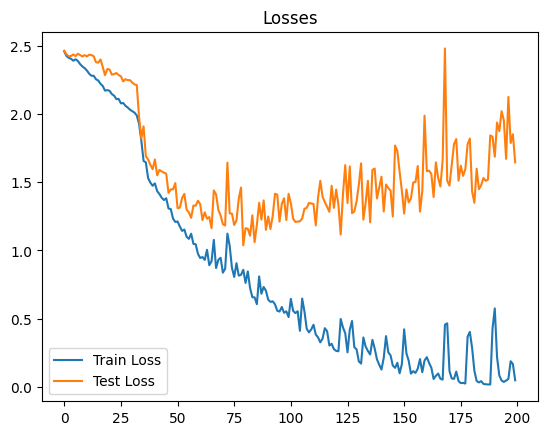

In [125]:
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['test_losses'], label='Test Loss')
plt.title("Losses")
plt.legend()
plt.show()

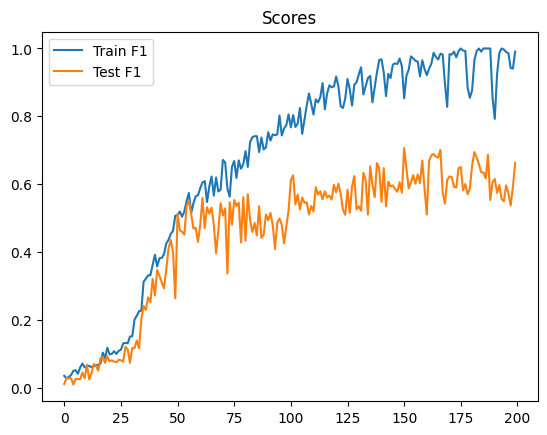

In [126]:
plt.plot(history['train_scores'], label="Train F1")
plt.plot(history['test_scores'], label="Test F1")
plt.title("Scores")
plt.legend()
plt.show()